In [202]:
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"

## GridWorldEnvironment
```py
start_point = (0,0)
end_point = (4,4)
gridworld_size = (5,5)
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [203]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1


    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)


    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]


    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state


    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

# Deep SARSA Class
1. 현재 상태 sₜ 에서
2. 어떤 행동 aₜ 를 수행하고
3. 실제로 벌어진 일:
   - 보상 rₜ₊₁을 받고
   - 다음 상태 sₜ₊₁로 이동하며
   - 다음 행동 aₜ₊₁를 선택
4. 그 결과를 바탕으로!
5. 다음 상태에서의 Q(sₜ₊₁, aₜ₊)를 신경망으로 추정하고, 목표값 target을 계산

$$
\text{target} = r_{t+1} + \gamma \cdot Q(s_{t+1}, a_{t+1})
$$




6. 처음에 했던 판단 Q(sₜ , aₜ)과 target의 차이로 손실을 계산하고, 신경망을 업데이트

$$
\text{loss} = \text{MSE}(Q(s_t, a_t),\ \text{target})
$$

-> 이 손실을 줄이기 위해 **역전파**를 사용하여 신경망의 파라미터를 조정!

In [204]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

In [205]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [206]:
env = GridWorldEnvironment(start_point=(0,0), #위 환경 클래스를 상속 받아 `env.render` 코드를 구현
                           end_point=(4,4),
                           grid_world_size=(5,5))

In [207]:
class DeepSARSA(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [208]:
class DeepSARSAAgent:
    def __init__(self, state_size, action_space):
        self.action_space = action_space
        self.num_actions = len(action_space)
        self.discount_factor = 0.9
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.1
        self.learning_rate = 0.001

        self.model = DeepSARSA(state_size, self.num_actions)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()


    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()


    def train(self, state, action, reward, next_state, next_action, done):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        q_values = self.model(state_tensor)
        q_value = q_values[0, action]

        with torch.no_grad():
            next_q_values = self.model(next_state_tensor)
            next_q_value = next_q_values[0, next_action]
            target = reward + (0 if done else self.discount_factor * next_q_value)
            target = torch.tensor(target, dtype=q_value.dtype)

        loss = self.loss_fn(q_value.unsqueeze(0), target.unsqueeze(0))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Main

- **Deep SARSA**를 이용해 그리드 월드 학습시키기  
- 학습 지표 시각화 (에피소드마다 에이전트의 이동 횟수 시각화)

In [209]:
agent = DeepSARSAAgent(state_size=2, action_space=env.action_space)

EPISODES = 1000
RENDER_PROCESS = False
RENDER_END = False
total_moves = []

for episode in range(EPISODES):
    state = env.start_point
    env.current_state = state
    env.traces = []

    state_array = np.array(state, dtype=np.float32)
    action_idx = agent.get_action(state_array)

    moves_cnt = 0
    done = False

    while not done:
        if RENDER_PROCESS:
            env.render()

        env.traces.append(env.current_state)

        next_state = env.state_after_action(state, action_idx)
        env.current_state = next_state

        reward = env.reward[next_state[0]][next_state[1]]
        done = (next_state == env.end_point)

        next_state_array = np.array(next_state, dtype=np.float32)
        next_action_idx = agent.get_action(next_state_array)

        agent.train(state_array, action_idx, reward, next_state_array, next_action_idx, done)

        state = next_state
        state_array = next_state_array
        action_idx = next_action_idx
        moves_cnt += 1

    env.traces.append(env.current_state)
    total_moves.append(moves_cnt)

    if (episode+1) % 100 == 0:
        print(f"[Episode]: {episode+1}/{EPISODES} __ [Num of Moves mean]:{np.mean(total_moves[episode-99:]):.1f} __ [Epsilon]: {agent.epsilon:.3f}")

    if RENDER_END:
        env.render()

<ipython-input-208-e7652315a695>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=q_value.dtype)


[Episode]: 100/1000 __ [Num of Moves mean]:16.6 __ [Epsilon]: 0.191
[Episode]: 200/1000 __ [Num of Moves mean]:9.3 __ [Epsilon]: 0.100
[Episode]: 300/1000 __ [Num of Moves mean]:8.7 __ [Epsilon]: 0.100
[Episode]: 400/1000 __ [Num of Moves mean]:8.9 __ [Epsilon]: 0.100
[Episode]: 500/1000 __ [Num of Moves mean]:9.2 __ [Epsilon]: 0.100
[Episode]: 600/1000 __ [Num of Moves mean]:8.8 __ [Epsilon]: 0.100
[Episode]: 700/1000 __ [Num of Moves mean]:9.0 __ [Epsilon]: 0.100
[Episode]: 800/1000 __ [Num of Moves mean]:8.9 __ [Epsilon]: 0.100
[Episode]: 900/1000 __ [Num of Moves mean]:8.9 __ [Epsilon]: 0.100
[Episode]: 1000/1000 __ [Num of Moves mean]:8.8 __ [Epsilon]: 0.100


In [210]:
# 마지막 결과 렌더링
env.render()

S X X . . 
. . X . . 
. . X X . 
. . . X X 
. . . . A 



In [211]:
import matplotlib.pyplot as plt

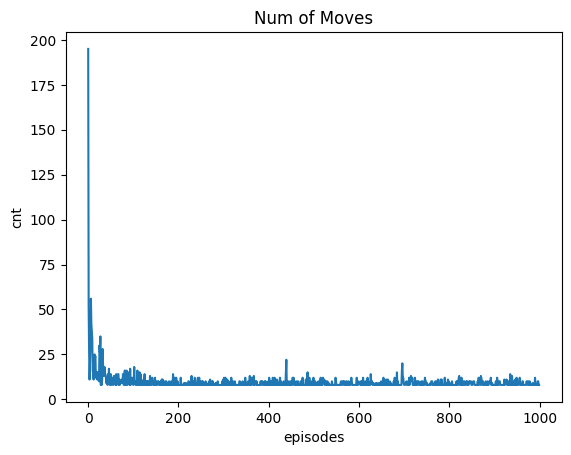

In [212]:
# 학습 후 최종 이동 결과 시각화
plt.plot(total_moves)
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()

---

# Q-learning Class
1. 현재 상태 sₜ 에서
2. 어떤 행동 aₜ 를 수행하고
3. 실제로 벌어진 일:
   - 보상 rₜ₊₁을 받고
   - 다음 상태 sₜ₊₁로 이동
4.  sₜ₊₁에서 가장 좋은 행동의 가치 max Q(sₜ₊₁, a)를 계산함 (이게 Q-learning의 핵심: 다음 행동은 직접 하지 않고 최대값만 참조)
5. 그 결과를 바탕으로!
6. 처음에 했던 판단 Q(sₜ, aₜ)이 얼마나 정확했는지 되돌아보고, 아래 수식을 따라 Q값을 수정

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t) \right]
$$

In [225]:
env = GridWorldEnvironment(start_point=(0,0), #위 환경 클래스를 상속 받아 `env.render` 코드를 구현
                           end_point=(4,4),
                           grid_world_size=(5,5))

In [226]:
from collections import defaultdict

In [233]:
class QlearningAgent:
    def __init__(self, action_space):
        # 행동에 관한 파라미터
        self.action_space = action_space
        self.num_actions = len(action_space)

        # 학습에 관련된 파라미터
        self.step_size = 0.01
        self.discount_factor = 0.9
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

        # 0을 초깃값으로 하는 큐함수 테이블 생성
        self.q_table = defaultdict(lambda: np.zeros(self.num_actions))


    def update_q_table(self, state, action_idx, reward, next_state):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        state = tuple(state)
        next_state = tuple(next_state)

        # 벨만 최적 방정식을 사용한 큐함수 업데이트
        q_1 = self.q_table[state][action_idx]
        q_2 = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action_idx] += self.step_size * (q_2 - q_1)


    def get_action(self, state):
        '''
        입실론 탐욕 정책(ε-greedy policy)을 통해 행동을 반환한다.
        '''
        state = tuple(state)
        # 0을 초깃값으로 하는 큐함수 테이블 생성
        if np.random.rand() < self.epsilon:
           return np.random.choice(range(self.num_actions))
        else:
            # 큐 함수에 따른 행동
            q_list = self.q_table[state]
            return self.argmax(q_list)


    def argmax(self, q_list):
        '''
        np.argmax를 사용하지 않고 별도의 매소드를 사용하는 이유
        Q-table에 값이 같은 action이 여러 개가 있다면,
        그중에서 랜덤으로 선택해야 하기 때문이다.
        '''
        max_value = np.amax(q_list)
        max_indices = np.where(q_list == max_value)[0]
        return random.choice(max_indices)


## Main


- **Q-learning**를 이용해 그리드 월드 학습시키기  
- 학습 지표 시각화 (에피소드마다 에이전트의 이동 횟수 시각화)

In [234]:
agent = QlearningAgent(env.action_space)

EPISODES = 1000
RENDER_PROCESS = False
RENDER_END = False
total_moves = []

In [235]:
for episode in range(EPISODES):
    state = env.start_point
    env.current_state = state
    env.traces = []

    moves_cnt = 0
    done = False

    while not done:
        if RENDER_PROCESS:
            env.render() # 이동을 출력하기

        env.traces.append(state)  # 이동 경로 기록

        # 현재 상태에 대한 행동 선택
        action_idx = agent.get_action(np.array(state, dtype=np.float32))      # 현재 상태에서 행동 선택
        next_state = env.state_after_action(state, action_idx)              # 현재 상태에서 행동 선택
        reward = env.reward[next_state[0]][next_state[1]]                 # 보상 획득
        done = (next_state == env.end_point)                              # 종료 조건 판단

        agent.update_q_table(state, action_idx, reward, next_state)      # Q-table 업데이트

        state = next_state
        moves_cnt += 1

    total_moves.append(moves_cnt)

    if (episode+1) % 100 == 0:
      recent = total_moves[-100:]  # 마지막 100개만 기준
      print(f"[Episode]: {episode+1}/{EPISODES} __ [Moves avg]:{np.mean(recent):.1f}  min:{np.min(recent)}  max:{np.max(recent)} __ [Epsilon]: {agent.epsilon:.3f}")

    env.current_state = state  # 마지막 위치로 확정
    if RENDER_END:
        env.render()

[Episode]: 100/1000 __ [Moves avg]:11.8  min:8  max:107 __ [Epsilon]: 0.010
[Episode]: 200/1000 __ [Moves avg]:8.1  min:8  max:10 __ [Epsilon]: 0.010
[Episode]: 300/1000 __ [Moves avg]:8.1  min:8  max:14 __ [Epsilon]: 0.010
[Episode]: 400/1000 __ [Moves avg]:8.1  min:8  max:12 __ [Epsilon]: 0.010
[Episode]: 500/1000 __ [Moves avg]:8.1  min:8  max:10 __ [Epsilon]: 0.010
[Episode]: 600/1000 __ [Moves avg]:8.0  min:8  max:10 __ [Epsilon]: 0.010
[Episode]: 700/1000 __ [Moves avg]:8.0  min:8  max:10 __ [Epsilon]: 0.010
[Episode]: 800/1000 __ [Moves avg]:8.1  min:8  max:10 __ [Epsilon]: 0.010
[Episode]: 900/1000 __ [Moves avg]:8.0  min:8  max:10 __ [Epsilon]: 0.010
[Episode]: 1000/1000 __ [Moves avg]:8.1  min:8  max:12 __ [Epsilon]: 0.010


In [236]:
print("Last episode moves:", moves_cnt)

Last episode moves: 8


In [237]:
# 마지막 학습 상황을 재현한다.
env.render()

S X . . . 
. X X . . 
. . X X X 
. . . . A 
. . . . G 



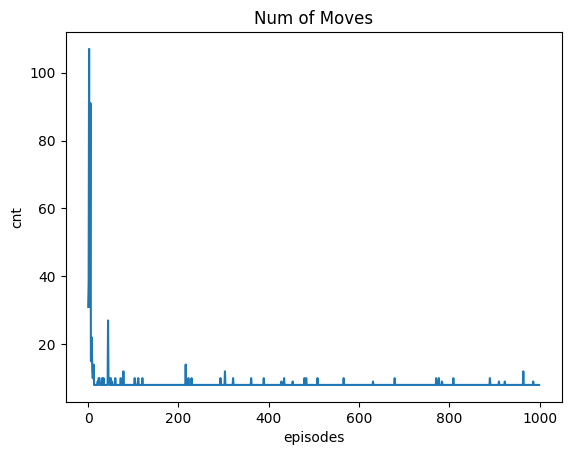

In [238]:
# 1000 에피소드에서 에이전트의 이동 횟수를 시각화
plt.plot(total_moves)
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()